# Predicting stock prices

The objective of this notebook is to predict the stock prices.

Data - YesBank.NS

Source - Yahoo Finance

### Importing libraries

In [1]:
import math
import numpy as np
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
from sklearn import preprocessing

### Get the dataset

In [2]:
#Data between START and END dates
start = datetime.datetime(2010, 9, 9)
end = datetime.datetime(2019, 9, 9)

df = web.DataReader("YESBANK.NS", 'yahoo', start, end)
print(df.tail())

                 High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2019-08-30  60.950001  55.500000  58.250000  59.950001  226395035.0  59.950001
2019-09-03  62.299999  57.650002  59.250000  58.750000  196326964.0  58.750000
2019-09-04  60.299999  57.250000  58.349998  59.450001  143742201.0  59.450001
2019-09-05  62.349998  58.849998  59.700001  61.950001  177914744.0  61.950001
2019-09-06  62.150002  59.599998   0.000000  60.400002  130649003.0  60.400002


### Exploring rolling mean

In [3]:
#Adj Close col of df
close_px = df['Adj Close']

In [4]:
#Rolling mean with window size=100
mavg = close_px.rolling(window=100).mean()

In [5]:
#Starting values are NaN as per window size
np.isnan(mavg).sum()

99

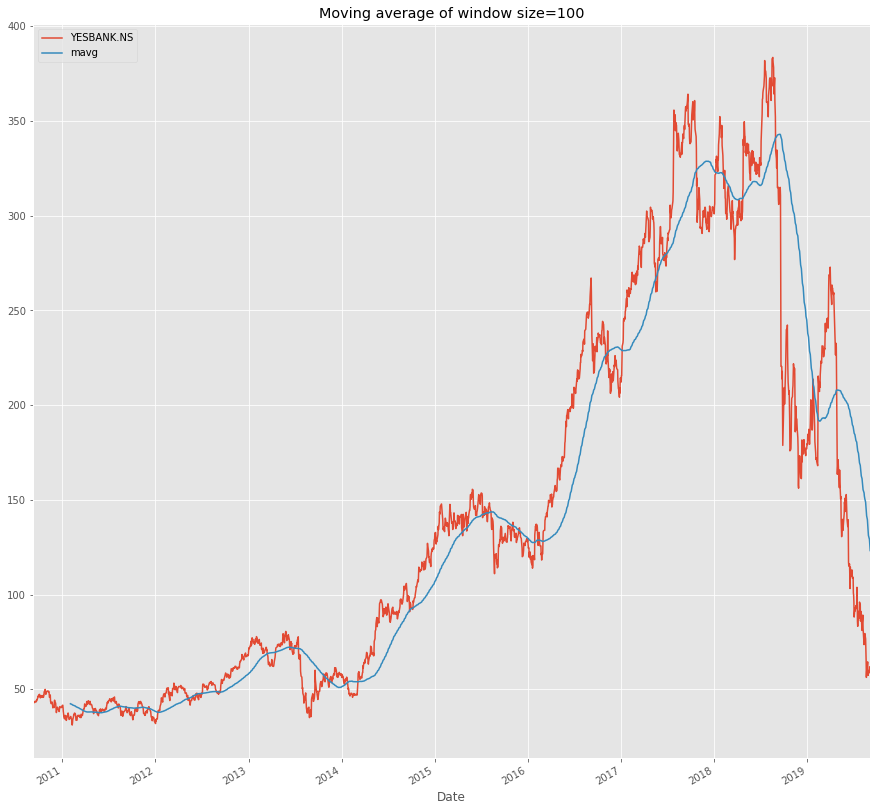

In [6]:
#For window size 100
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(15, 15))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='YESBANK.NS')
mavg.plot(label='mavg')
plt.legend()
plt.title("Moving average of window size=100")
plt.show()

In [7]:
#Rolling mean with window size=20 and window size=9
mavg20 = close_px.rolling(window=20).mean()
mavg9 = close_px.rolling(window=9).mean()

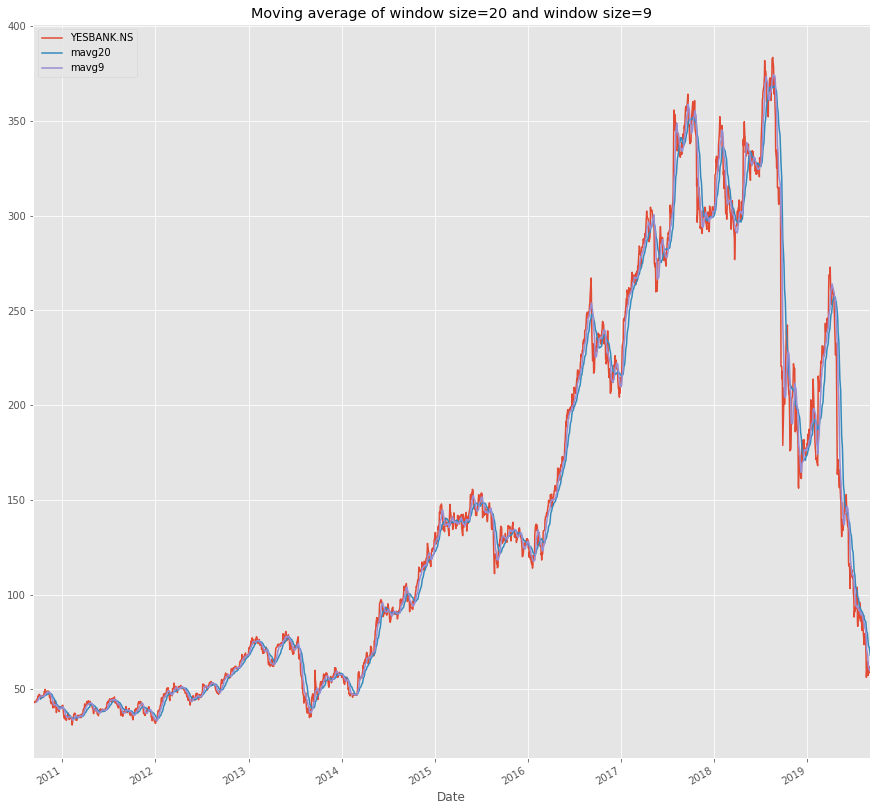

In [8]:
#For window size 20
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(15, 15))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='YESBANK.NS')
mavg20.plot(label='mavg20')
mavg9.plot(label='mavg9')
plt.legend()
plt.title("Moving average of window size=20 and window size=9")
plt.show()

### Data visualization

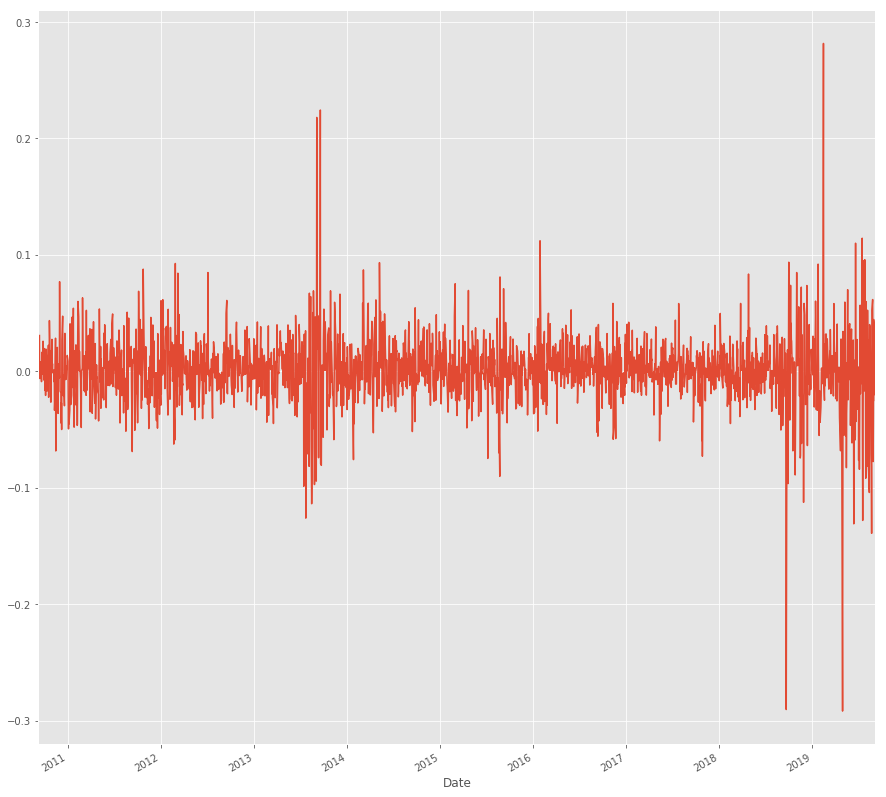

In [9]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')
plt.show()

In [10]:
#Finding correlation with its competitors
dfcomp = web.DataReader(['YESBANK.NS', 'AXISBANK.NS', 'ICICIBANK.NS', 'HDFCBANK.NS', 'KOTAKBANK.NS', 'SBIN.NS'],'yahoo',start=start,end=end)['Adj Close']

In [11]:
retscomp = dfcomp.pct_change()
corr = retscomp.corr()

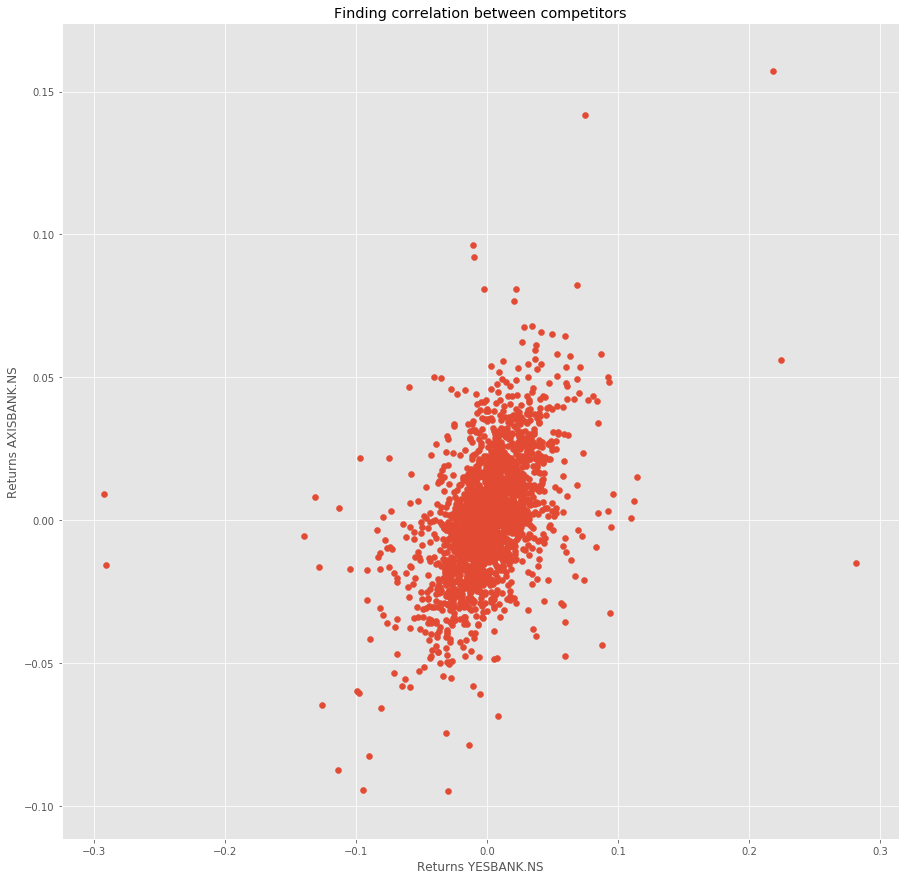

In [12]:
plt.scatter(retscomp['YESBANK.NS'], retscomp['AXISBANK.NS'])
plt.xlabel("Returns YESBANK.NS")
plt.ylabel("Returns AXISBANK.NS")
plt.title("Finding correlation between competitors")
plt.show()

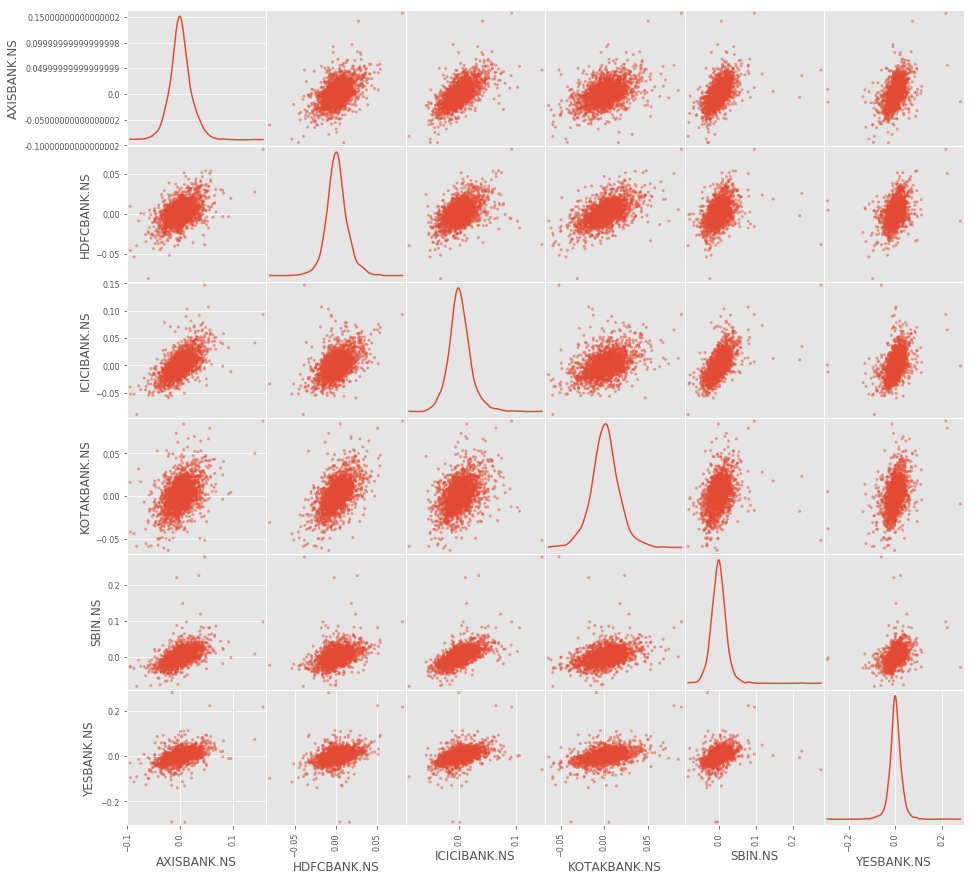

In [13]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(15, 15));

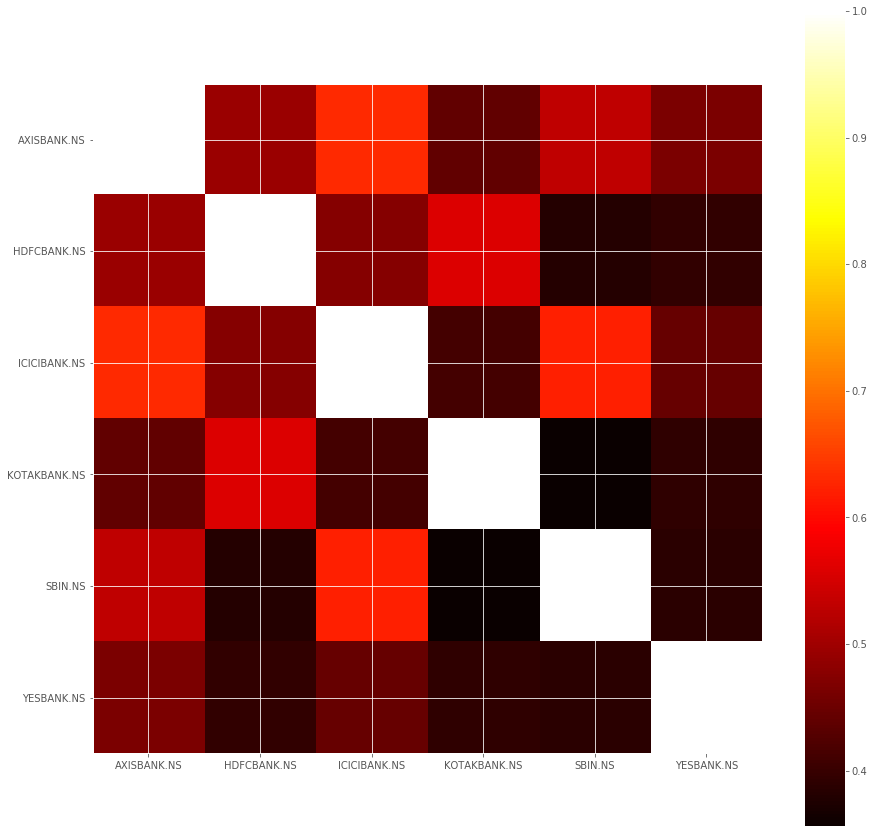

In [14]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

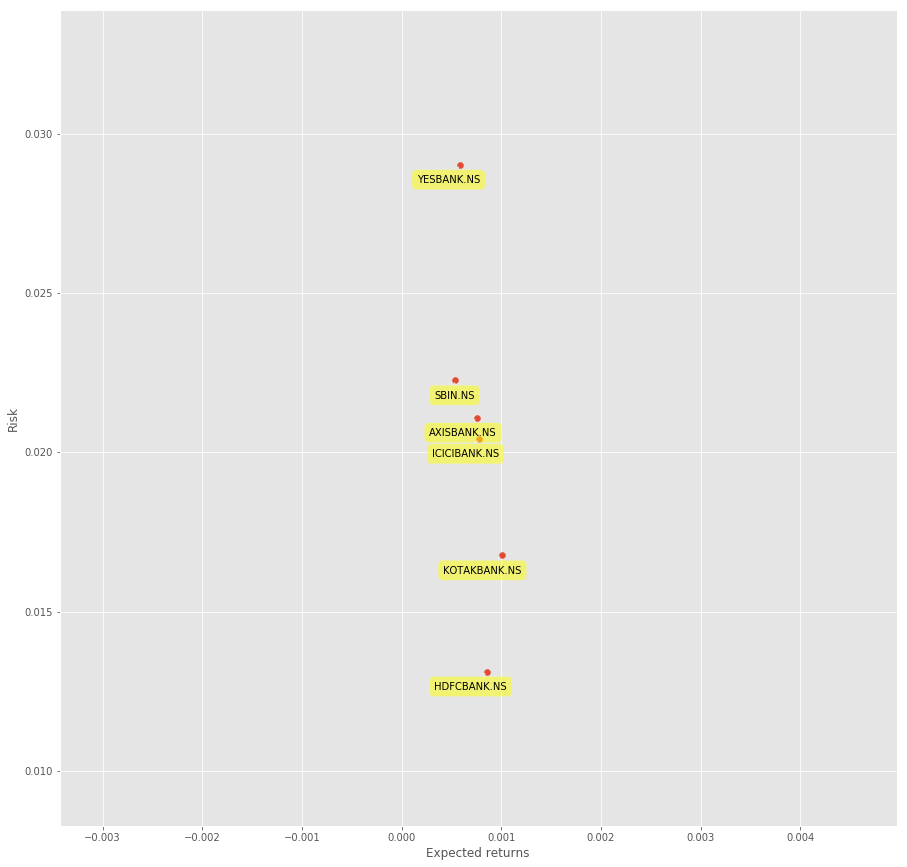

In [15]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

### Creating train and test data

In [16]:
window_size = 32 # Allow us to look at 32 days into the past
# Prepare the data so that we have 32 day windows and predict what the next day should be

# Get indices of access for the data
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

In [17]:
data = df['Adj Close'].values[indices] # Create the 2D matrix of training samples

In [18]:
X = data[:,:-1] # Each row represents 32 days in the past
y = data[:,-1] # Each output value represents the 33rd day

In [19]:
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

### Method 1: Ridge Regression

In [20]:
from sklearn.linear_model import Ridge
#Train
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Infer
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_ridge = ridge_model.predict(X_test)

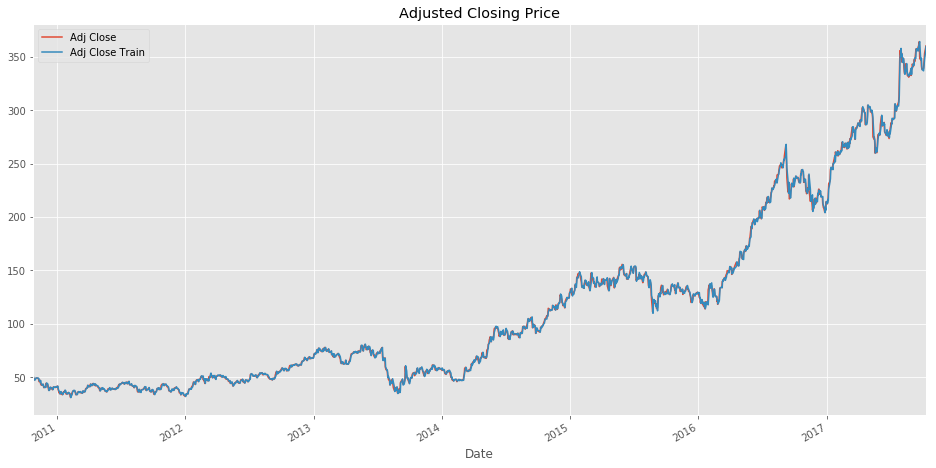

In [21]:
# Plot what it looks like for the training data
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_ridge['Adj Close Train'] = y_pred_train_ridge[:-window_size]
df_ridge.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

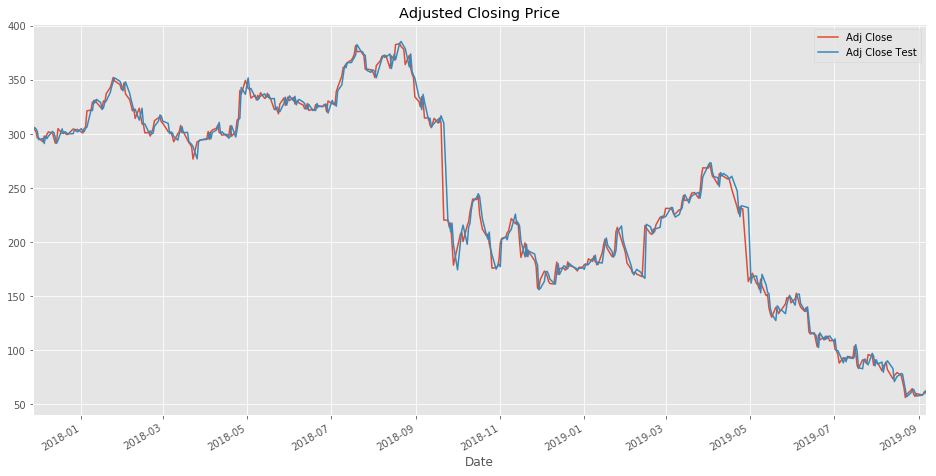

In [22]:
# Same for the test
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_ridge['Adj Close Test'] = y_pred_ridge
df_ridge.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

### Method 2: Bayesian Regression

In [23]:
from sklearn.linear_model import BayesianRidge
#Train
bayesian_model = BayesianRidge()
bayesian_model.fit(X_train, y_train)

#Infer
y_pred_train_bayesian = bayesian_model.predict(X_train)
y_pred_bayesian = bayesian_model.predict(X_test)

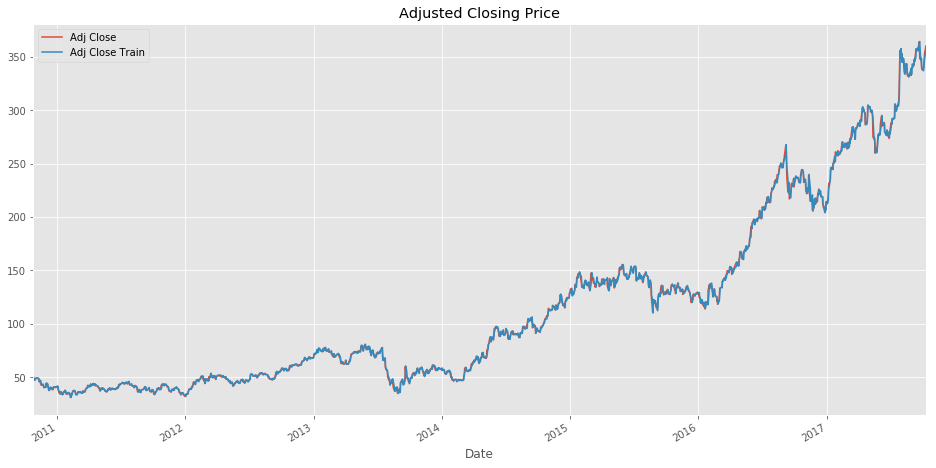

In [24]:
# Plot what it looks like for the training data
df_bayesian = df.copy()
df_bayesian.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_bayesian = df_bayesian.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_bayesian['Adj Close Train'] = y_pred_train_bayesian[:-window_size]
df_bayesian.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

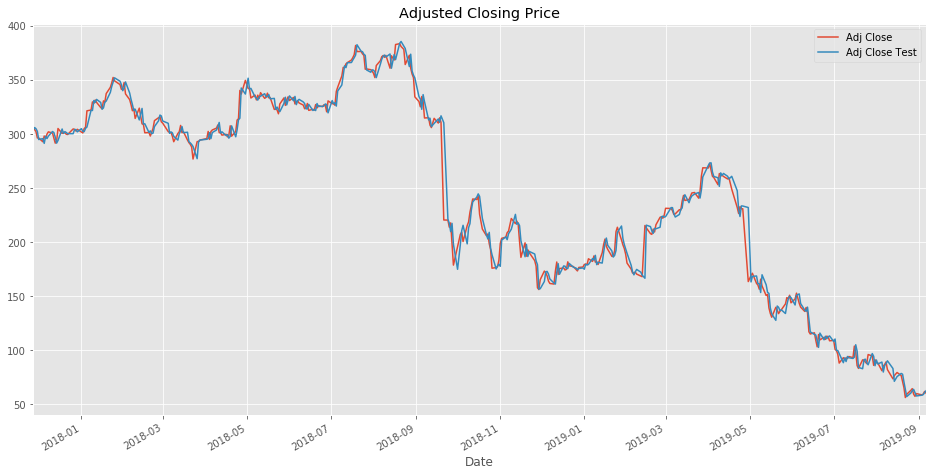

In [25]:
# Same for the test
df_bayesian = df.copy()
df_bayesian.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_bayesian = df_bayesian.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_bayesian['Adj Close Test'] = y_pred_bayesian
df_bayesian.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

### Method 3: Decision Tree Regressor

In [26]:
from sklearn.tree import DecisionTreeRegressor
#Train
dectree_model = DecisionTreeRegressor(max_depth=50)
dectree_model.fit(X_train,y_train)

#Infer
y_pred_train_dectree = dectree_model.predict(X_train)
y_pred_dectree = dectree_model.predict(X_test)

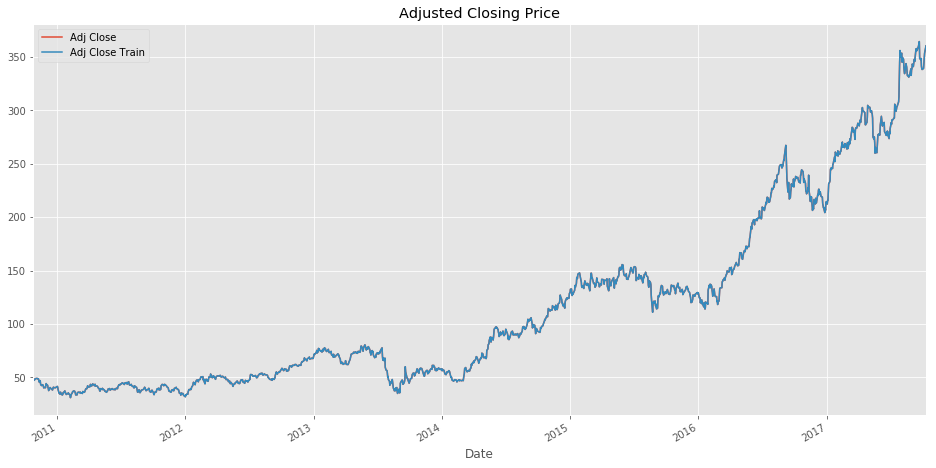

In [27]:
# Plot what it looks like for the training data
df_dectree = df.copy()
df_dectree.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_dectree = df_dectree.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_dectree['Adj Close Train'] = y_pred_train_dectree[:-window_size]
df_dectree.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

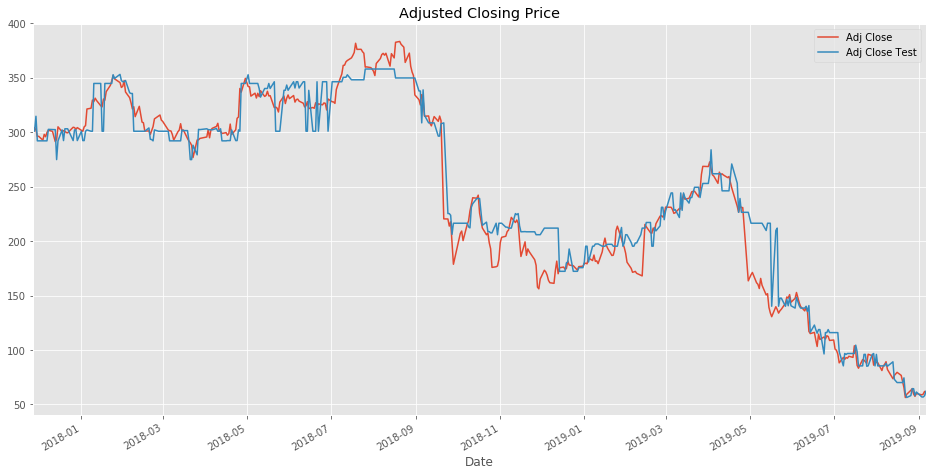

In [28]:
# Same for the test
df_dectree = df.copy()
df_dectree.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_dectree = df_dectree.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_dectree['Adj Close Test'] = y_pred_dectree
df_dectree.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

### Method 4: SVM Regressor

In [29]:
from sklearn.svm import SVR
#Train
svr_model = SVR(gamma='auto')
svr_model.fit(X_train,y_train)

#Infer
y_pred_train_svr = svr_model.predict(X_train)
y_pred_svr = svr_model.predict(X_test)

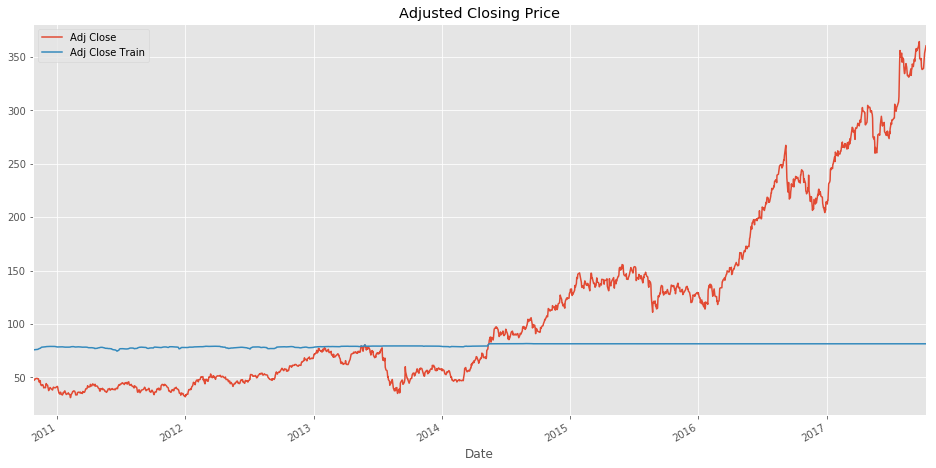

In [30]:
# Plot what it looks like for the training data
df_svr = df.copy()
df_svr.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_svr = df_svr.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_svr['Adj Close Train'] = y_pred_train_svr[:-window_size]
df_svr.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

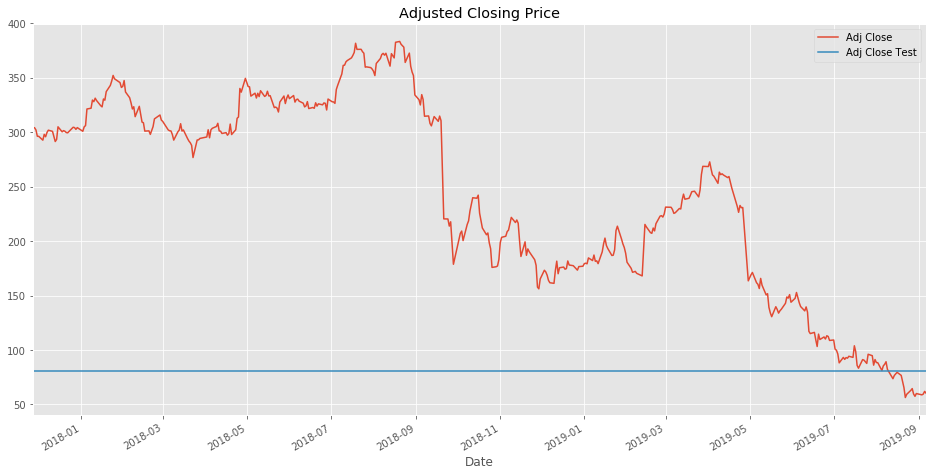

In [31]:
# Same for the test
df_svr = df.copy()
df_svr.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_svr = df_svr.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_svr['Adj Close Test'] = y_pred_svr
df_svr.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

### Method 5: Gradient Boosting Trees

In [32]:
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Infer
y_pred_train_gb = gb_model.predict(X_train)
y_pred_gb = gb_model.predict(X_test)

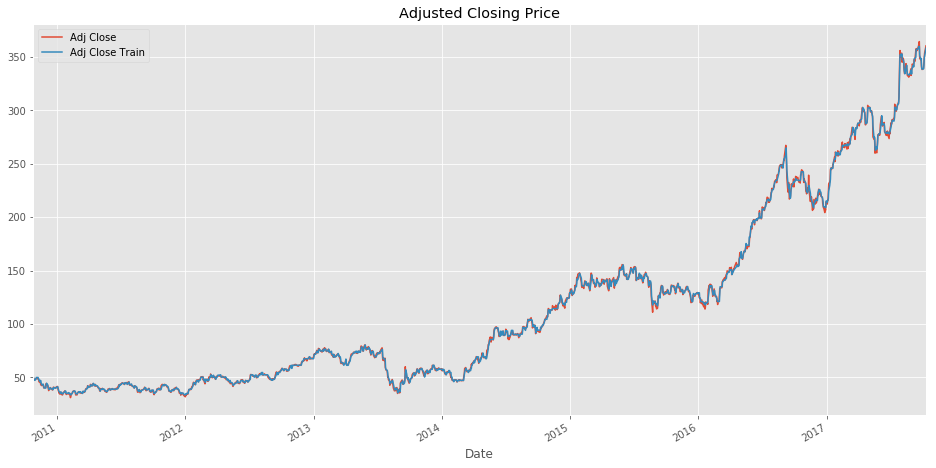

In [33]:
# Plot what it looks like for the training data
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_gb['Adj Close Train'] = y_pred_train_gb[:-window_size]
df_gb.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

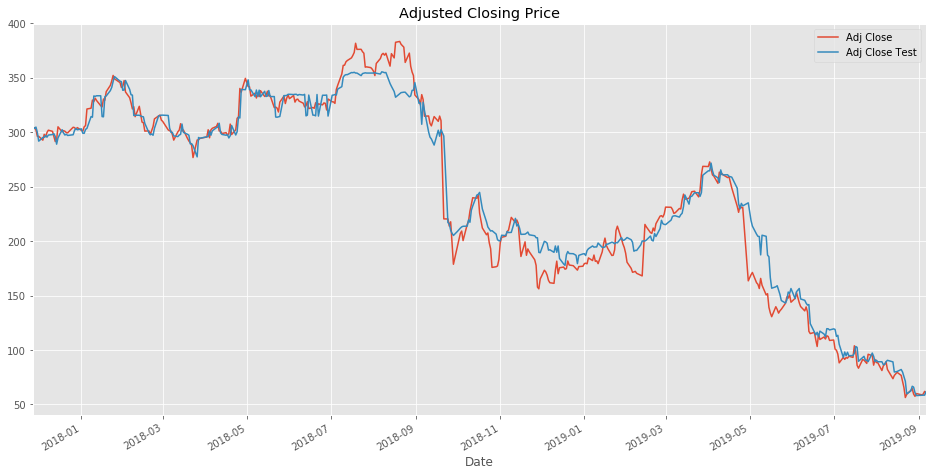

In [34]:
# Same for the test
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_gb['Adj Close Test'] = y_pred_gb
df_gb.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

#### Best results are given by bayesian regression